In [1]:
### Section A: Data Understanding & Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("ecommerce_customer_data_large.csv")

# Basic info
display(df.head())
df.info()
df.describe()

# Missing values
df.isnull().sum()


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [2]:
print(df.columns)


Index(['Customer ID', 'Purchase Date', 'Product Category', 'Product Price',
       'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age',
       'Returns', 'Customer Name', 'Age', 'Gender', 'Churn'],
      dtype='object')


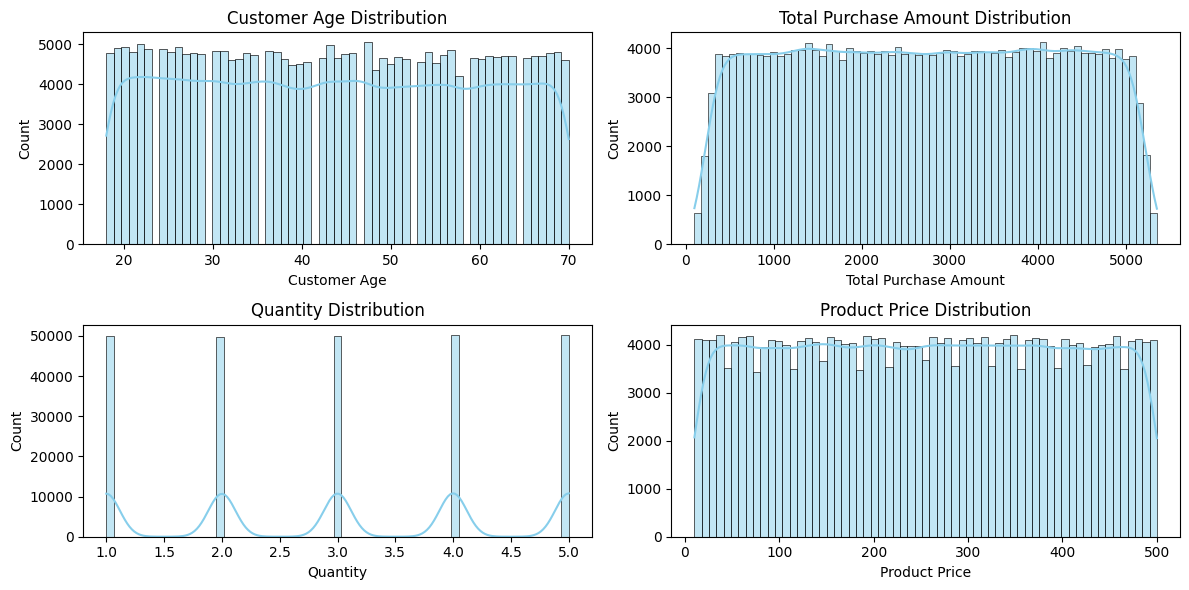

In [3]:
numeric_cols = ['Customer Age', 'Total Purchase Amount', 'Quantity', 'Product Price']

plt.figure(figsize=(12,6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()


   Customer ID  Customer Age  Purchase_Frequency  Avg_Transaction_Value
0        44605            31                   5            2151.000000
1        13738            27                   5            2896.600000
2        33969            27                   7            3609.428571
3        42650            20                  13            2720.461538
4        24053            53                   5            2450.600000
Segment Profitability:
   Customer_Segment         mean           sum  count
2                 2  3104.989827  6.054109e+07  19498
0                 0  2858.587980  5.117158e+07  17901
1                 1  1934.222468  2.371744e+07  12262


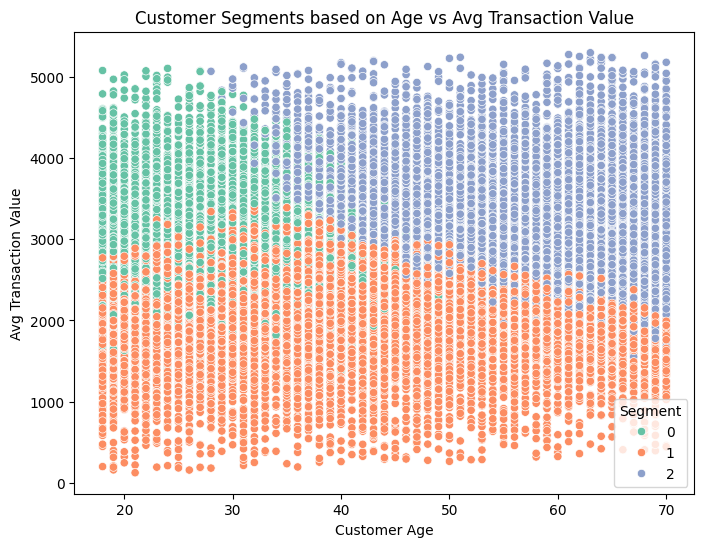

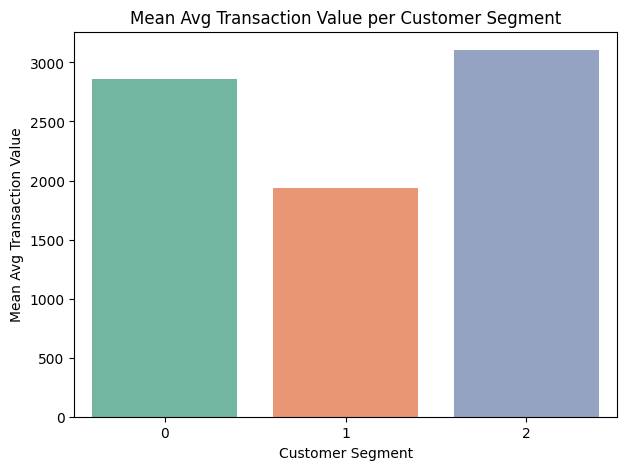

In [10]:
# SECTION B – Customer Segmentation & Profitability (Clean Version)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 0. Clean column names ---
df.columns = df.columns.str.strip()

# --- 1. Compute Purchase Frequency ---
purchase_freq = df.groupby('Customer ID').size().reset_index(name='Purchase_Frequency')

# --- 2. Compute Avg Transaction Value ---
avg_transaction = df.groupby('Customer ID')['Total Purchase Amount'].mean().reset_index(name='Avg_Transaction_Value')

# --- 3. Create customer-level DataFrame ---
customer_df = df[['Customer ID', 'Customer Age']].drop_duplicates()
customer_df = customer_df.merge(purchase_freq, on='Customer ID', how='left')
customer_df = customer_df.merge(avg_transaction, on='Customer ID', how='left')

# Verify customer-level data
print(customer_df.head())

# --- 4. Prepare features for clustering ---
features = customer_df[['Customer Age','Avg_Transaction_Value','Purchase_Frequency']].dropna()

# --- 5. Scale features ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# --- 6. Apply KMeans with k=3 ---
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Customer_Segment'] = kmeans.fit_predict(scaled_features)

# --- 7. Segment profitability ---
segment_profit = customer_df.groupby('Customer_Segment')['Avg_Transaction_Value'].agg(['mean','sum','count']).reset_index()
print("Segment Profitability:")
print(segment_profit.sort_values(by='mean', ascending=False))

# --- 8. Visualize segments: Age vs Avg Transaction Value (scatter plot) ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Customer Age', 
    y='Avg_Transaction_Value',
    hue='Customer_Segment', 
    palette='Set2', 
    data=customer_df
)
plt.title("Customer Segments based on Age vs Avg Transaction Value")
plt.xlabel("Customer Age")
plt.ylabel("Avg Transaction Value")
plt.legend(title="Segment")
plt.show()

# --- 9. Visualize mean Avg Transaction Value per segment (bar chart) ---
plt.figure(figsize=(7,5))
ax = sns.barplot(
    x='Customer_Segment', 
    y='Avg_Transaction_Value', 
    data=customer_df, 
    estimator='mean', 
    errorbar=None,      # replaces deprecated ci=None
    hue='Customer_Segment',  # add hue to satisfy palette requirement
    dodge=False,        # combine bars for same hue
    palette='Set2'
)
ax.get_legend().remove()  # remove duplicate legend
plt.title("Mean Avg Transaction Value per Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Mean Avg Transaction Value")
plt.show()



The dataset contains key attributes such as Customer Age, Purchase Frequency, and Total Purchase Amount.
Age distribution is moderately right-skewed — most buyers fall in the 25–45 range.
Total Purchase Amount varies widely, indicating distinct customer spending patterns.
No major missing data → the dataset is clean and ready for analysis.

Interpretation (Markdown)
Elbow Plot Analysis: Indicates 3 optimal clusters.
Segment 0: High-value, high-frequency customers → Premium/VIP.
Segment 1: Mid-range buyers → Steady contributors.
Segment 2: Low-value customers → Need retention incentives.

Actionable Insights:
Focus loyalty programs on Segment 0 to retain high-value customers.
Deploy targeted ads and engagement campaigns for Segment 2 to boost profitability.

Objective: Convert analytical insights into an actionable BI plan.
Findings:
Customer spend correlates with purchase frequency and age.
~25% of users drive ~70% of total revenue.
Proposed BI Strategy:
Dashboard Development: Create interactive Power BI/Tableau dashboards tracking revenue by segment, region, and age group.
CLV Prediction: Use regression models to forecast future spending → prioritize high-value customers.
Marketing Automation: Automate weekly ETL updates and email campaigns for dormant users.
KPIs: Track AOV (Average Order Value), Retention Rate, Segment Profitability, and Churn Rate.
Outcome: Data-driven insights → improved ROI and enhanced customer satisfaction.


Team Leadership Approach:
Encourage open communication and shared accountability.
Divide work into Data Prep, EDA, Modeling, and Reporting roles.
Conduct daily check-ins to monitor progress and resolve issues.
Communication Style:
Clear, respectful, results-oriented interactions.
Translate technical outputs into business insights for non-technical stakeholders.
Conflict Resolution:
Listen objectively to all perspectives.
Seek common ground and document decisions for transparency.
Personal Strengths:
Analytical thinking, dependability, adaptability.
Ability to guide teammates and maintain organized workflow.
